In [17]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
from urllib.parse import urlparse
from skimage.io import imread
from PIL import Image
from PIL import ImageFilter
from skimage.transform import resize
import image_utils as iu
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, LSTM, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from keras import Input, Model
from keras.preprocessing.image import ImageDataGenerator


In [14]:
data_path = 'data'
# Training paths
training_path = os.path.join(data_path, 'train-data')
train_path = os.path.join(training_path, 'train')
val_path = os.path.join(training_path, 'val')
test_path = os.path.join(training_path, 'test')
# Checkpoint path
checkpoint_path = os.path.join(training_path, 'train_ckpt')
checkpoint_file_path = os.path.join(checkpoint_path, "cp.ckpt")


In [37]:

# create a data generator
datagen = ImageDataGenerator()
# load and iterate training dataset
b_size = 64
image_size = (320, 320)
train_it = datagen.flow_from_directory(
    train_path, class_mode='categorical', batch_size=b_size, target_size=image_size)
# load and iterate validation dataset
val_it = datagen.flow_from_directory(
    val_path, class_mode='categorical', batch_size=b_size, target_size=image_size)
# load and iterate test dataset
test_it = datagen.flow_from_directory(
    test_path, class_mode='categorical', batch_size=b_size, target_size=image_size)


Found 42607 images belonging to 4 classes.
Found 7987 images belonging to 4 classes.
Found 2662 images belonging to 4 classes.


ValueError: num must be 1 <= num <= 40, not 41

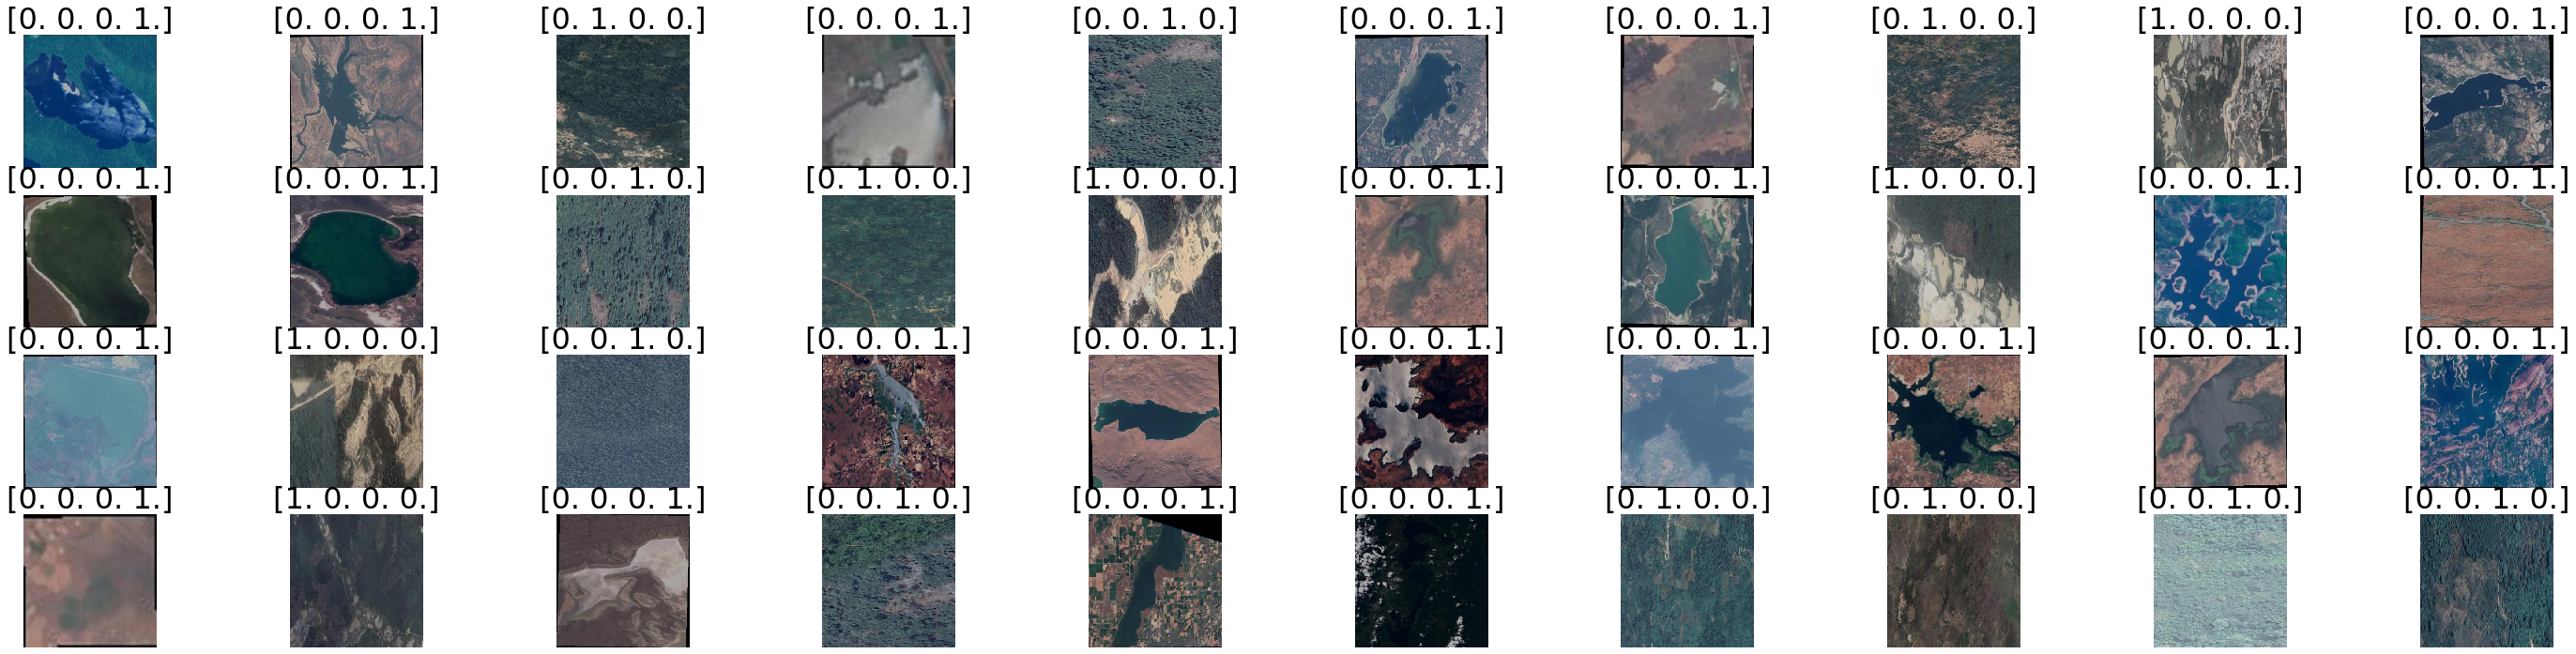

In [75]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(50, 12), rows=4, cols= 10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize=figsize)
    # cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=32)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


imgs, labels = next(train_it)
plots(imgs, titles=labels)

In [45]:
labels

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],


In [12]:
train_it.class_indices.keys()


dict_keys(['mining-site', 'settlement', 'vegetation', 'waterbody'])

In [117]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

In [41]:
image_dimen = 320
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
            input_tensor=Input(shape=(image_dimen, image_dimen, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable=False
# flatten the max-pooling output of VGG
flatten=vgg.output
flatten=Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead=Dense(128, activation="relu")(flatten)
bboxHead=Dense(64, activation="relu")(bboxHead)
bboxHead=Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="softmax")(bboxHead)
model=Model(inputs=vgg.input, outputs=bboxHead)
            # compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                          optimizer='adam')
model.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 320, 320, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 320, 320, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 160, 160, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 160, 160, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 160, 160, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 80, 80, 128)       0   

In [42]:
# fit model
model.fit(train_it, epochs=100, batch_size=64,
                    validation_data=val_it, callbacks=[cp_callback])


Epoch 1/100
  1/666 [..............................] - ETA: 2:42:15 - loss: 4.8142 - accuracy: 0.1719
Epoch 00001: saving model to data/train-data/train_ckpt/cp.ckpt
  2/666 [..............................] - ETA: 9:08:07 - loss: 5.4833 - accuracy: 0.2266
Epoch 00001: saving model to data/train-data/train_ckpt/cp.ckpt


KeyboardInterrupt: 

In [118]:
history = model.fit_generator(
    train_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    epochs=2,
    validation_data=val_it,
    validation_steps=val_it.samples/val_it.batch_size,
    verbose=1, callbacks=[cp_callback])


/Users/ernestopoku-kwarteng/virtualenvs/django3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
665/665 [==============================] - 8758s 13s/step - loss: 0.1115 - accuracy: 0.9757 - val_loss: 0.1459 - val_accuracy: 0.9529

Epoch 00001: saving model to data/train-data/train_ckpt/cp.ckpt
Epoch 2/2
665/665 [==============================] - 8082s 12s/step - loss: 0.0797 - accuracy: 0.9810 - val_loss: 0.1521 - val_accuracy: 0.9578

Epoch 00002: saving model to data/train-data/train_ckpt/cp.ckpt


In [68]:
test_imgs, test_labels = next(test_it)
predictions = model.predict(test_imgs)

In [110]:
im = iu.read_image('/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/Mining-Site-Detection/data/train-data/test/mining-site/4cb65a4f-ed4e-4aff-bff3-cd080c6dc010.jpg', 'RGB')


In [111]:
im = im.resize((320, 320))

In [112]:
np_im = np.asarray(im)

In [96]:
np_im.shape

(320, 320, 3)

In [113]:
pred = model.predict(np.array(np_im).reshape(1,320, 320, 3))

In [114]:
pred

array([[9.9998951e-01, 4.2110659e-07, 4.6034179e-06, 5.3948443e-06]],
      dtype=float32)

In [115]:
np.round(pred)

array([[1., 0., 0., 0.]], dtype=float32)

In [78]:
predictions

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.71592365e-10, 1.72884541e-03, 9.98271108e-01, 1.24232575e-15],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.66905253e-09, 1.47080643e-03, 9.98529196e-01, 4.65898709e-11],
       [6.07587390e-06, 7.86501635e-03, 9.92128968e-01, 6.35628794e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [9.99937892e-01, 6.14923265e-05, 3.02906670e-07, 2.14315619e-07],
       [5.22249117e-02, 1.17476366e-01, 8.30297053e-01, 1.67054111e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [3.75316618e-18, 7.84302999e-27, 3.88239792e-30, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [2.56104773e-04, 5.41949272e-01, 4.57794607e-01, 2.09745465e-08],
       [8.32252278e-37, 2.14775443e-31, 7.70287351e

In [63]:
np.round(predictions[2])


array([0., 0., 1., 0.], dtype=float32)

In [64]:
np.argmax(np.round(predictions[2]))

2

In [69]:
categories = []
for p in predictions:
    categories.append(np.argmax(np.round(p)))

In [70]:
categories

[3,
 2,
 3,
 3,
 2,
 2,
 3,
 0,
 2,
 3,
 3,
 3,
 1,
 3,
 3,
 2,
 3,
 2,
 2,
 0,
 3,
 3,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 3,
 0,
 3,
 0,
 0,
 3,
 0,
 3,
 3,
 2,
 3,
 3,
 3,
 0,
 1,
 2,
 3,
 3,
 3,
 2,
 1,
 3,
 2,
 3,
 3,
 1,
 3]

ValueError: num must be 1 <= num <= 40, not 41

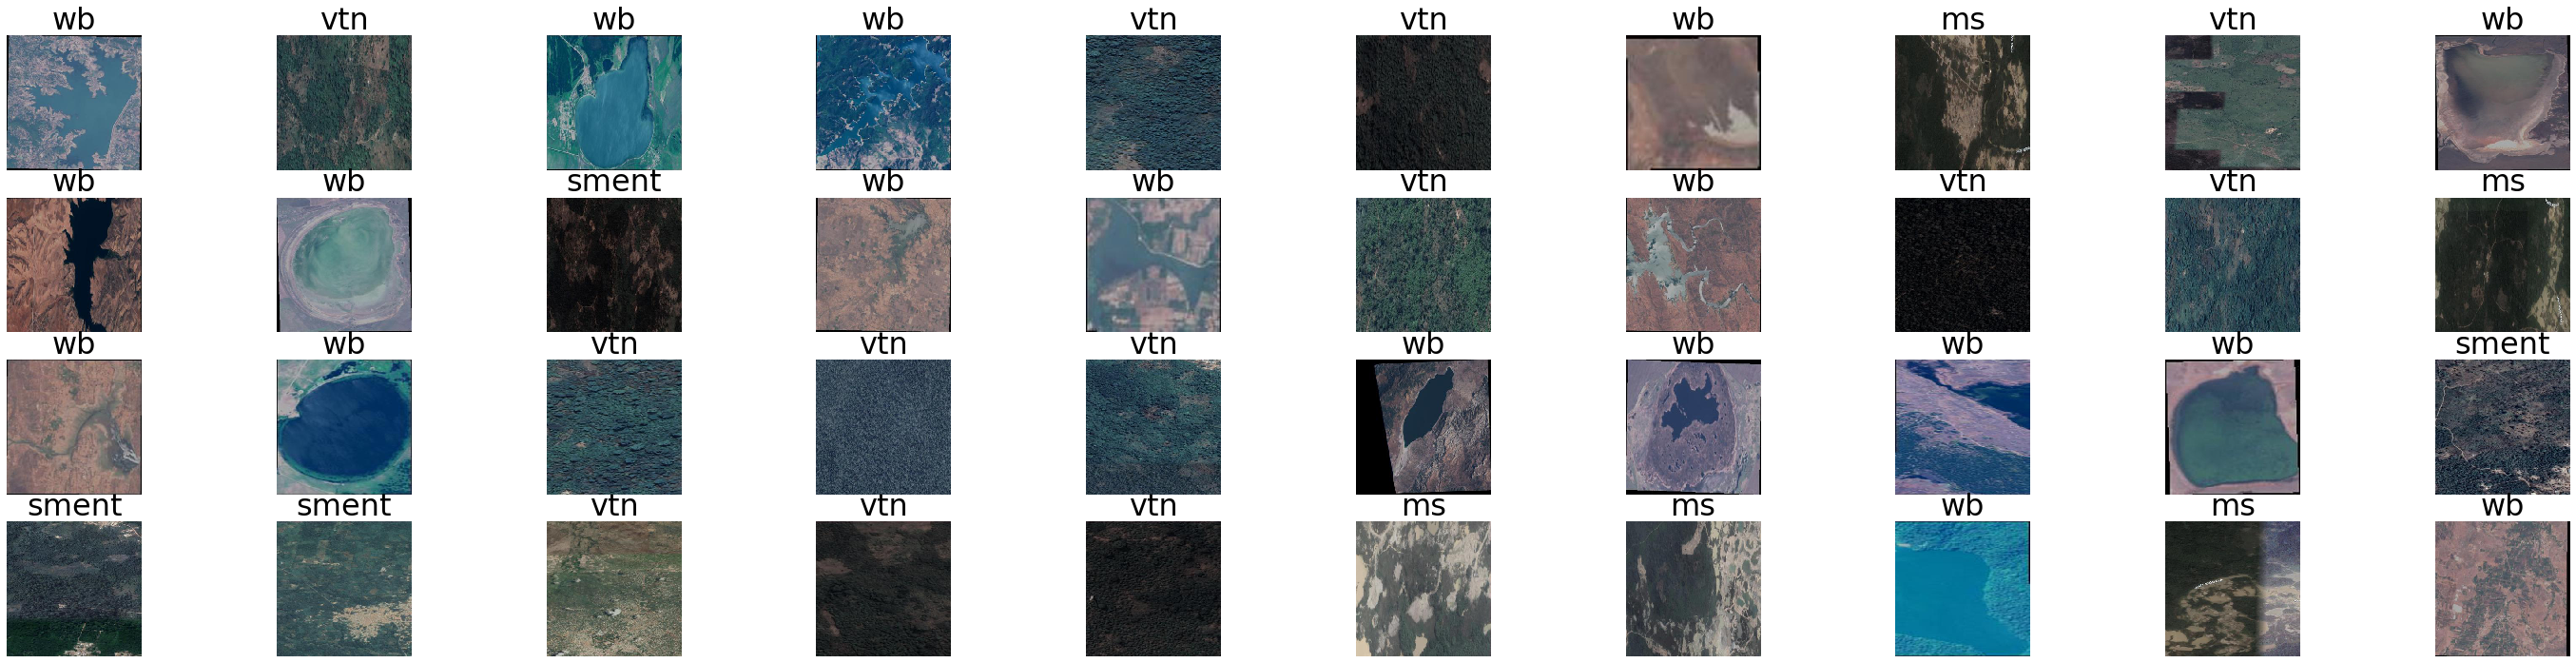

In [76]:
def to_label(value):
    if value == 0:
        return 'ms'
    elif value == 1:
        return 'sment'
    elif value == 2:
        return 'vtn'
    elif value == 3:
        return 'wb'


# test_imgs, test_labels = next(test_it)
# predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:, 1]
df['predicted'] = categories
df['predicted_labels'] = df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, titles=df['predicted_labels'])


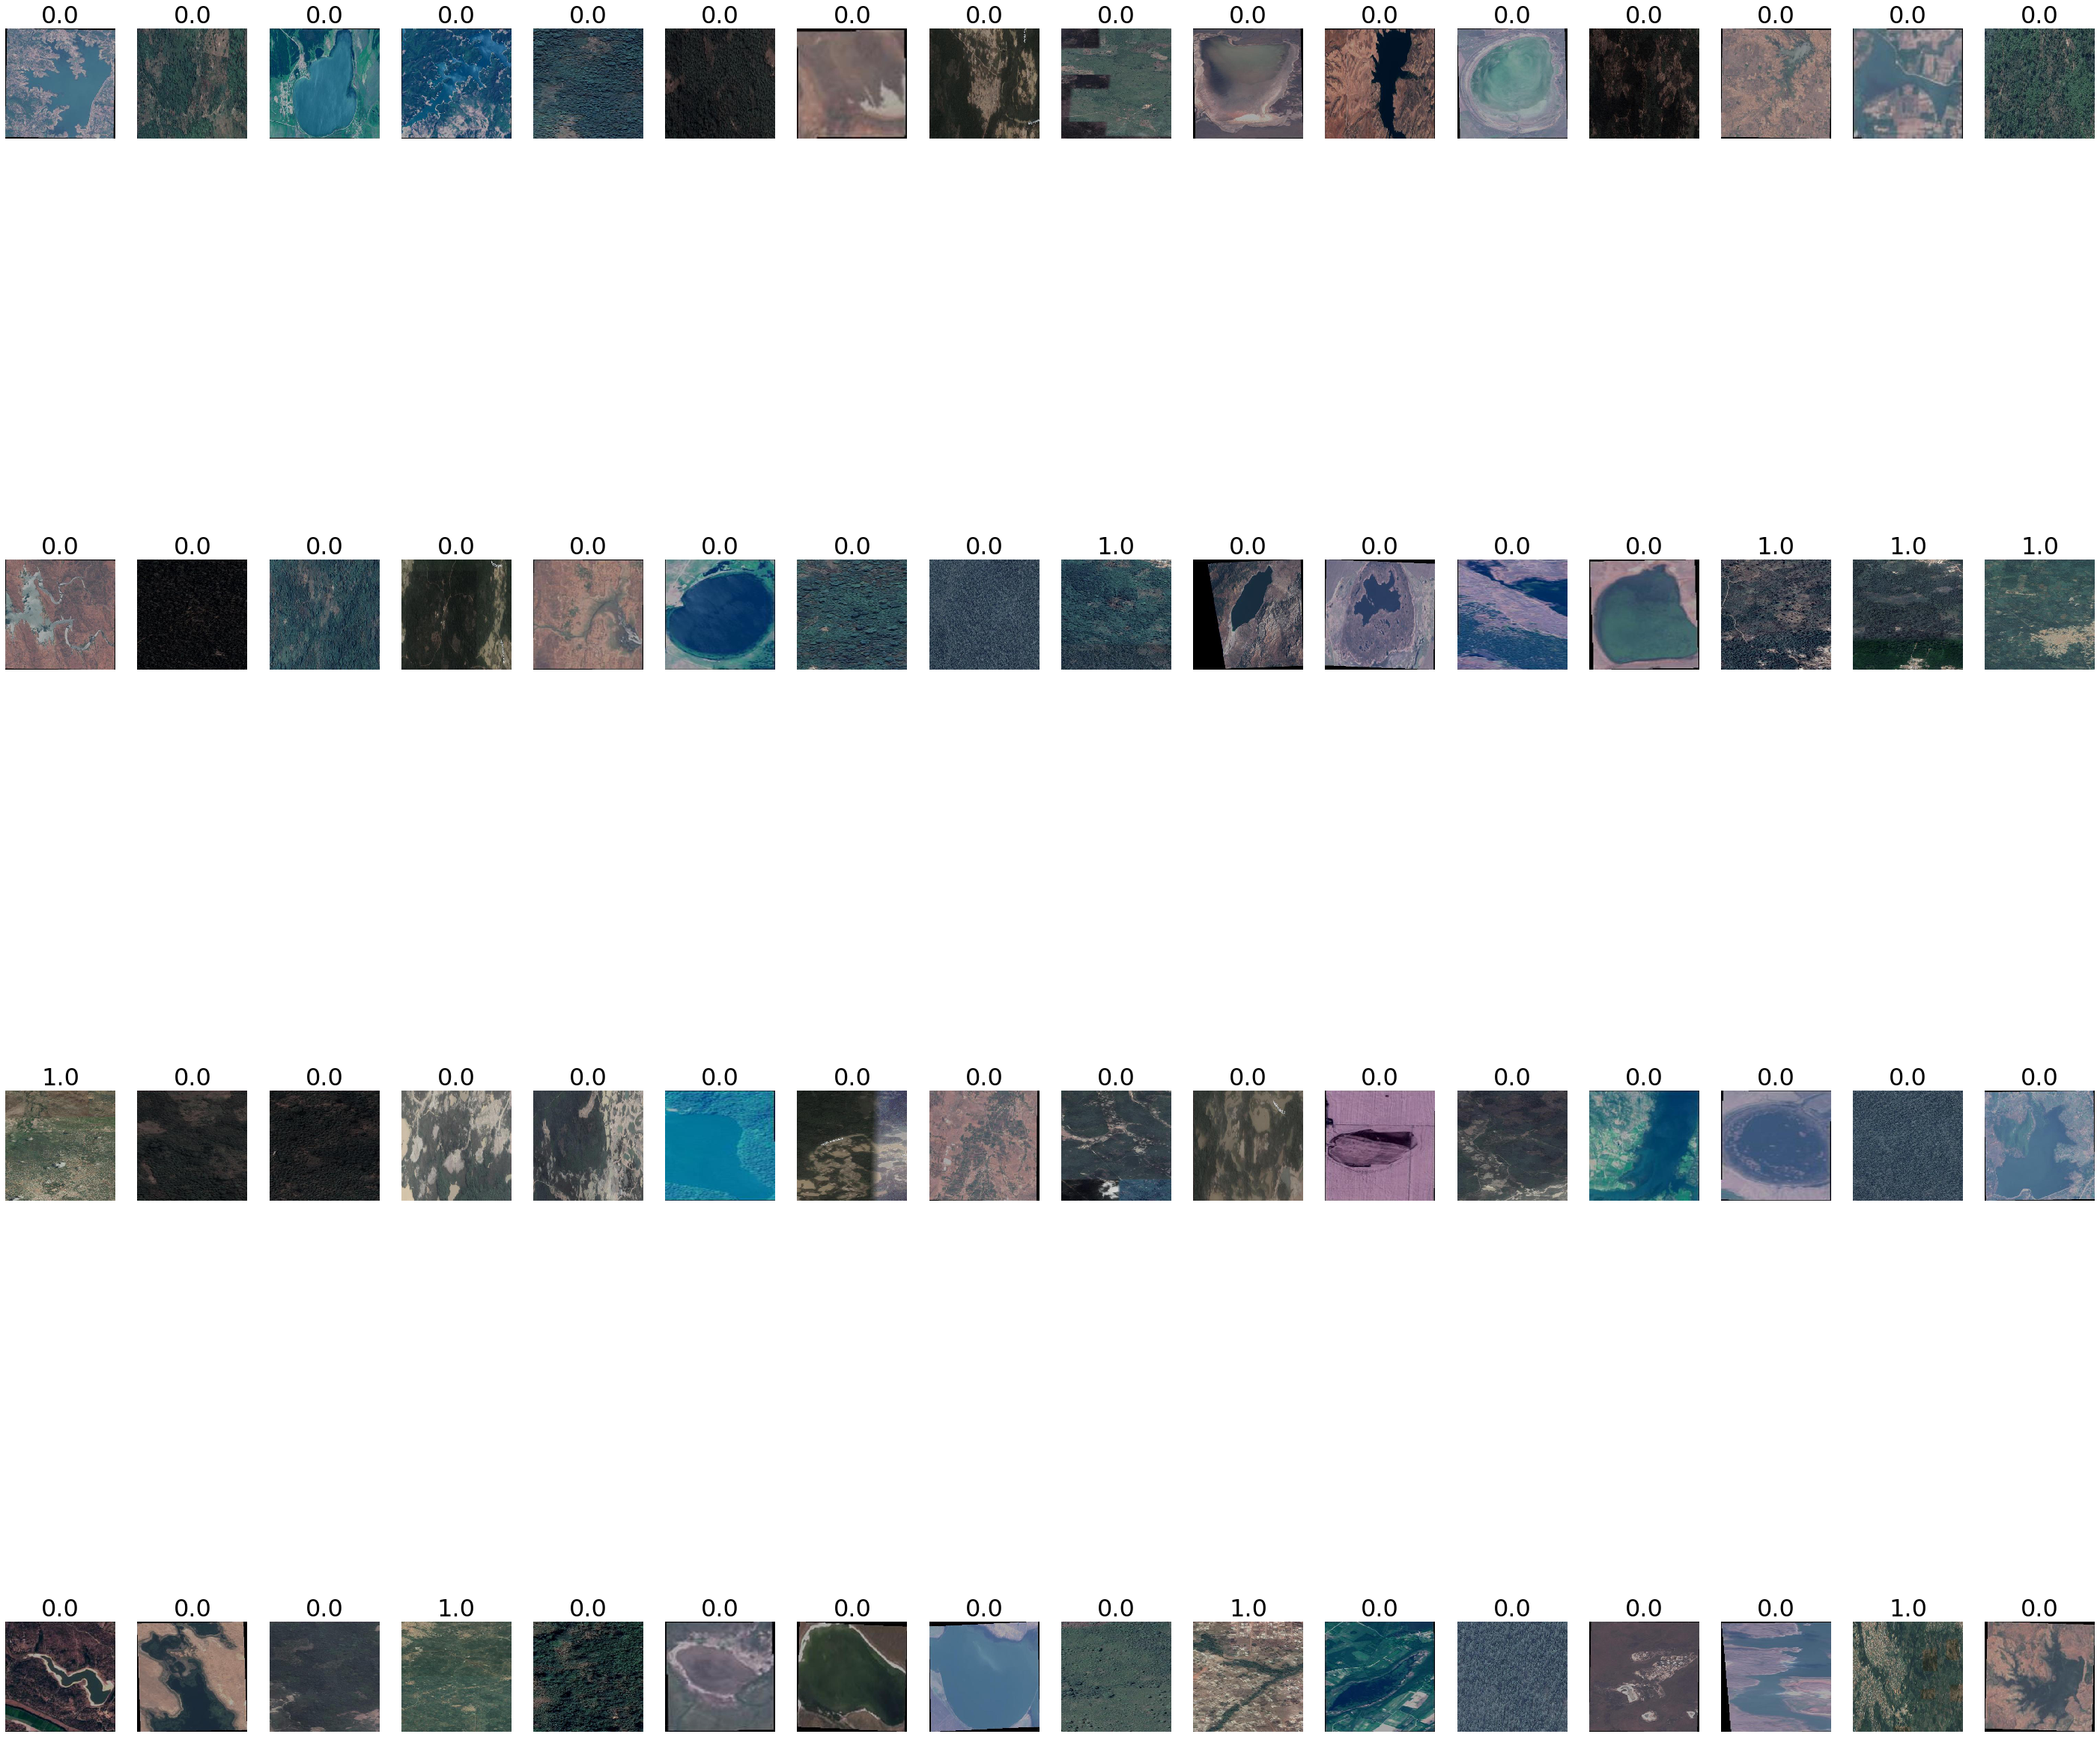

In [72]:
def to_label(value):
    if value == 0:
        return 'mining-site'
    elif value == 1:
        return 'settlement'
    elif value == 2:
        return 'vegetation'
    elif value == 3:
        return 'waterbody'


# test_imgs, test_labels = next(test_it)
# predictions = model.predict(test_imgs)

df = pd.DataFrame()
df['actual'] = test_labels[:, 1]
df['predicted'] = categories
df['predicted_labels'] = df['predicted'].map(lambda x: to_label(x))
plots(test_imgs, titles=df['actual'])
